# [DistilBERT, a distilled version of BERT: smaller, faster, cheaper and lighter](https://arxiv.org/abs/1910.01108)

In this lecture, we will explore the architecture of DistilBERT, its key components, and how it can be utilized for various natural language processing tasks. Additionally, we'll discuss its advantages, limitations, and provide hands-on examples to showcase its effectiveness.

Reference : [The Theory](https://towardsdatascience.com/distillation-of-bert-like-models-the-code-73c31e8c2b0a) | [Code](https://towardsdatascience.com/distillation-of-bert-like-models-the-theory-32e19a02641f)

In [397]:
# import os
# Set GPU device
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# os.environ['http_proxy']  = 'http://192.41.170.23:3128'
# os.environ['https_proxy'] = 'http://192.41.170.23:3128'

In [398]:
!pip install datasets
!pip install evaluate

In [399]:
# !pip install datasets --upgrade
import datasets
from datasets import load_dataset
import transformers
import torch
datasets.__version__, transformers.__version__, torch.__version__

import torch.nn as nn
import torch
from tqdm.auto import tqdm
import random, math, time


In [400]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

cuda


## 1. Loading our MNLI part of the GLUE dataset

In [401]:
# connect with google drive
from google.colab import drive
drive.mount('/content/drive')

# declare file path with os
import os
os.chdir('/content/drive/MyDrive/_NLP/A7/NLP-A7-Distillation_vs_LoRA')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [402]:
raw_datasets = load_dataset("Hate-speech-CNERG/hatexplain")
print(raw_datasets)

# testing another dataset
# raw_datasets = load_dataset("tweets-hate-speech-detection/tweets_hate_speech_detection")
# print(raw_datasets)


DatasetDict({
    train: Dataset({
        features: ['id', 'annotators', 'rationales', 'post_tokens'],
        num_rows: 15383
    })
    validation: Dataset({
        features: ['id', 'annotators', 'rationales', 'post_tokens'],
        num_rows: 1922
    })
    test: Dataset({
        features: ['id', 'annotators', 'rationales', 'post_tokens'],
        num_rows: 1924
    })
})


In [403]:
print(raw_datasets)

DatasetDict({
    train: Dataset({
        features: ['id', 'annotators', 'rationales', 'post_tokens'],
        num_rows: 15383
    })
    validation: Dataset({
        features: ['id', 'annotators', 'rationales', 'post_tokens'],
        num_rows: 1922
    })
    test: Dataset({
        features: ['id', 'annotators', 'rationales', 'post_tokens'],
        num_rows: 1924
    })
})


In [404]:
print(raw_datasets['train'][5])

{'id': '18790322_gab', 'annotators': {'label': [2, 1, 1], 'annotator_id': [203, 202, 204], 'target': [['Hispanic'], ['Hispanic', 'Refugee'], ['Hispanic', 'Refugee']]}, 'rationales': [], 'post_tokens': ['i', 'live', 'and', 'work', 'with', 'many', 'legal', 'mexican', 'immigrants', 'who', 'are', 'great', 'citizens', 'and', 'trump', 'supporters', 'they', 'have', 'no', 'problem', 'with', 'deporting', 'illegals', 'maga']}


In [405]:
from collections import Counter
print(Counter(raw_datasets['test']['annotators'][0]))  # Try for all entries


Counter({'label': [1, 1, 1], 'annotator_id': [9, 17, 64], 'target': [['None'], ['None'], ['None']]})


In [406]:
# HateXplain label definitions
label_list = ["hate_speech", "normal", "offensive"]
label2id = {label: idx for idx, label in enumerate(label_list)}
id2label = {idx: label for label, idx in label2id.items()}

print(id2label)


{0: 'hate_speech', 1: 'normal', 2: 'offensive'}


## 2. Model & Tokenization

In [407]:
import numpy as np
# Extract unique labels from "annotators" field
num_labels = np.unique([label for labels in raw_datasets["train"]["annotators"] for label in labels]).size

print("Number of unique labels:", num_labels)

Number of unique labels: 3


In [408]:
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer

teacher_id = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(teacher_id)

teacher_model = AutoModelForSequenceClassification.from_pretrained(
    teacher_id,
    num_labels = num_labels,
    id2label = id2label,
    label2id = label2id,
)

teacher_model

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

## 3. Preprocessing

In [409]:
# def tokenize_function(examples):
#     # Convert tokenized list into full sentences
#     text_inputs = [" ".join(tokens) for tokens in examples["post_tokens"]]

#     # Tokenize with dynamic padding
#     return tokenizer(text_inputs, max_length=128, truncation=True, padding=True)


In [410]:
def tokenize_function(examples):
    # Convert tokenized list into full sentences
    text_inputs = [" ".join(tokens) for tokens in examples["post_tokens"]]

    # Tokenize with dynamic padding
    tokenized_output = tokenizer(text_inputs, max_length=128, truncation=True, padding=True)

    # Important: remove the id
    # if 'id' in examples:
    #     tokenized_output['id'] = examples['id']  # Add original id to the tokenized output

    return tokenized_output

In [411]:
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
tokenized_datasets

Map:   0%|          | 0/1922 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'annotators', 'rationales', 'post_tokens', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 15383
    })
    validation: Dataset({
        features: ['id', 'annotators', 'rationales', 'post_tokens', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1922
    })
    test: Dataset({
        features: ['id', 'annotators', 'rationales', 'post_tokens', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1924
    })
})

In [412]:
#list data from tokenized
# tokenized_datasets['train'][0]['input_ids']

In [413]:
from collections import Counter

def convert_labels(example):
    batch_labels = []

    for annotators in example["annotators"]:  # Each annotator entry (dict)
        labels = annotators.get("label", [])

        # Keep only valid integer labels
        valid_labels = [int(l) for l in labels if isinstance(l, (int, float, str)) and str(l).isdigit()]

        # Majority vote or fallback
        if valid_labels:
            most_common = Counter(valid_labels).most_common(1)[0][0]
        else:
            most_common = 1  # Default to 'normal' if no valid label

        batch_labels.append(most_common)

    return {"labels": batch_labels}


In [414]:
tokenized_datasets_with_labels = tokenized_datasets.map(convert_labels, batched=True)

# Drop old 'annotators' field
tokenized_datasets_with_labels = tokenized_datasets_with_labels.remove_columns(["annotators"])

# Final dataset with labels
tokenized_datasets = tokenized_datasets_with_labels


Map:   0%|          | 0/1922 [00:00<?, ? examples/s]

In [415]:
import numpy as np
print(np.unique(tokenized_datasets['test']['labels'], return_counts=True))

(array([0, 1, 2]), array([594, 782, 548]))


In [416]:
import numpy as np
print(np.unique(tokenized_datasets['validation']['labels'], return_counts=True))

(array([0, 1, 2]), array([593, 781, 548]))


In [417]:
import numpy as np
print(np.unique(tokenized_datasets['train']['labels'], return_counts=True))

(array([0, 1, 2]), array([4748, 6251, 4384]))


In [418]:
print(tokenized_datasets)

DatasetDict({
    train: Dataset({
        features: ['id', 'rationales', 'post_tokens', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 15383
    })
    validation: Dataset({
        features: ['id', 'rationales', 'post_tokens', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 1922
    })
    test: Dataset({
        features: ['id', 'rationales', 'post_tokens', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 1924
    })
})


In [419]:
# tokenized_datasets['train'][0]

In [420]:
print(tokenizer.pad_token_id)  # Typically returns 0
print(tokenizer.pad_token)  # Typically returns [PAD]

0
[PAD]


In [421]:
non_padded_tokens = [token for token in tokenized_datasets['train'][0]['input_ids'] if token != tokenizer.pad_token_id]
print(non_padded_tokens)


[101, 1057, 2428, 2228, 1045, 2052, 2025, 2031, 2042, 15504, 2011, 18993, 7560, 2030, 5152, 2067, 1999, 2634, 2030, 7269, 1998, 1037, 9253, 6394, 2052, 9040, 2033, 2004, 2092, 2074, 2000, 2156, 2033, 5390, 102]


In [422]:
decoded_text = tokenizer.decode(non_padded_tokens)
print(decoded_text)


[CLS] u really think i would not have been raped by feral hindu or muslim back in india or bangladesh and a neo nazi would rape me as well just to see me cry [SEP]


In [423]:
tokenizer.decode(tokenized_datasets['train'][0]['input_ids'])

'[CLS] u really think i would not have been raped by feral hindu or muslim back in india or bangladesh and a neo nazi would rape me as well just to see me cry [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'





## 4. Preparing the dataloader

In [424]:
tokenized_datasets = tokenized_datasets.remove_columns(['id','rationales','post_tokens'])

In [384]:
# tokenized_datasets.set_format("torch")

In [385]:
# tokenized_datasets['train']

In [391]:
# # Before creating DataLoader, remove 'id' from the dataset if it exists:
# tokenized_datasets = tokenized_datasets.remove_columns(["id"])


In [425]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
#Data collator that will dynamically pad the inputs received.

In [426]:
small_train_dataset = tokenized_datasets["train"].shuffle(seed=1150).select(range(10000))
small_eval_dataset = tokenized_datasets["validation"].shuffle(seed=1150).select(range(1000))
small_test_dataset = tokenized_datasets["test"].shuffle(seed=1150).select(range(1000))


In [427]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(
    small_train_dataset, shuffle=True, batch_size=32, collate_fn=data_collator)
test_dataloader = DataLoader(
    small_test_dataset, batch_size=32, collate_fn=data_collator)
eval_dataloader = DataLoader(
    small_eval_dataset, batch_size=32, collate_fn=data_collator)

In [389]:
# # prepare for Dataloader

# from torch.utils.data import DataLoader

# train_dataloader = DataLoader(
#     tokenized_datasets["train"], batch_size=8, shuffle=True, collate_fn=data_collator
# )
# eval_dataloader = DataLoader(
#     tokenized_datasets["validation"], batch_size=8, shuffle=False, collate_fn=data_collator
# )
# test_dataloader = DataLoader(
#     tokenized_datasets["test"], batch_size=8, shuffle=False, collate_fn=data_collator
# )


In [428]:
for batch in train_dataloader:
    break

batch['labels'].shape, batch['input_ids'].shape, batch['attention_mask'].shape

(torch.Size([32]), torch.Size([32, 128]), torch.Size([32, 128]))

In [429]:
for batch in train_dataloader:
    print(batch.keys())  # Ensure it includes 'input_ids', 'attention_mask', 'labels'
    print(batch["input_ids"].shape)
    print(batch["attention_mask"].shape)
    print(batch["labels"].shape)
    break


dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'labels'])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])


In [430]:
# for batch in train_dataloader:
#     break

# print(batch["input_ids"].shape, batch["attention_mask"].shape, batch["labels"].shape)


## 5. Design the model and losses

### 5.1 Teacher Model & Student Model

####  Architecture
In the present work, the student - DistilBERT - has the same general architecture as BERT.
- The `token-type embeddings` and the `pooler` are removed while `the number of layers` is reduced by a factor of 2.
- Most of the operations used in the Transformer architecture `linear layer` and `layer normalisation` are highly optimized in modern linear algebra frameworks.
- our investigations showed that variations on the last dimension of the tensor (hidden size dimension) have a smaller impact on computation efficiency (for a fixed parameters budget) than variations on other factors like the number of layers.
- Thus we focus on reducing the number of layers.

#### Initialize Student Model
- To initialize a new model from an existing one, we need to access the weights of the old model (the teacher).
- In order to get the weights, we first have to know how to access them. We’ll use BERT as our teacher model.

In [431]:
teacher_model.config

BertConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "hate_speech",
    "1": "normal",
    "2": "offensive"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "hate_speech": 0,
    "normal": 1,
    "offensive": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.49.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

####
- The student model has the same configuration, except the number of layers is reduced by a factor of 2
- The student layers are initilized by copying one out of two layers of the teacher, starting with layer 0.
- The head of the teacher is also copied.

In [432]:
from transformers.models.bert.modeling_bert import BertPreTrainedModel, BertConfig
# Get teacher configuration as a dictionnary
configuration = teacher_model.config.to_dict()
# configuration

In [433]:
# Half the number of hidden layer
configuration['num_hidden_layers'] //= 2
# Convert the dictionnary to the student configuration
configuration = BertConfig.from_dict(configuration)

In [434]:
# Create uninitialized student model
model = type(teacher_model)(configuration)
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-5): 6 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, e

- Recursively copies the weights of the (teacher) to the (student).
- This function is meant to be first called on a BertFor... model, but is then called on every children of that model recursively.
- The only part that's not fully copied is the encoder, of which only half is copied.

In [435]:
from transformers.models.bert.modeling_bert import BertEncoder, BertModel
from torch.nn import Module

def distill_bert_weights(
    teacher: Module,
    student: Module,
    use_odd_layers: bool = True  # Flag to select odd or even layers
) -> None:
    """
    Copies weights from the teacher model to the student model.
    - If `use_odd_layers=True`, copies odd-numbered layers {1, 3, 5, 7, 9, 11}.
    - If `use_odd_layers=False`, copies even-numbered layers {2, 4, 6, 8, 10, 12}.
    """
    if isinstance(teacher, BertModel) or type(teacher).__name__.startswith('BertFor'):
        for teacher_part, student_part in zip(teacher.children(), student.children()):
            distill_bert_weights(teacher_part, student_part, use_odd_layers)

    elif isinstance(teacher, BertEncoder):
        teacher_encoding_layers = [layer for layer in next(teacher.children())]  # 12 layers
        student_encoding_layers = [layer for layer in next(student.children())]  # 6 layers

        #  Select Odd or Even Layers
        selected_layers = range(1, 12, 2) if use_odd_layers else range(0, 12, 2)

        for i, layer_idx in enumerate(selected_layers):
            student_encoding_layers[i].load_state_dict(teacher_encoding_layers[layer_idx].state_dict())

    else:
        student.load_state_dict(teacher.state_dict())

    return student  # Fix: Return the student model after weight copying


In [436]:
# model = distill_bert_weights(teacher=teacher_model, student=model)

In [437]:
student_model_odd = distill_bert_weights(teacher=teacher_model, student=model, use_odd_layers=True)
student_model_even = distill_bert_weights(teacher=teacher_model, student=model, use_odd_layers=False)

In [438]:
def count_parameters(m):
    return sum(p.numel() for p in m.parameters() if p.requires_grad)

print('Teacher parameters :', count_parameters(teacher_model))
print('Student parameters :', count_parameters(student_model_odd))

Teacher parameters : 109484547
Student parameters : 66957315


In [439]:
def count_parameters(m):
    return sum(p.numel() for p in m.parameters() if p.requires_grad)

print('Teacher parameters :', count_parameters(teacher_model))
print('Student parameters :', count_parameters(student_model_even))

Teacher parameters : 109484547
Student parameters : 66957315


In [440]:
count_parameters(model)/count_parameters(teacher_model) * 100

61.15686353435797

In [441]:
# Move models to the available device
student_model_odd.to(device)
student_model_even.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-5): 6 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, e

In [442]:
#It has 40% less parameters than bert-base-uncased

### 5.2 Loss function

#### Softmax

$$
P_i(\mathbf{z}_i, T) = \frac{\exp(\mathbf{z}_i / T)}{\sum_{q=0}^k \exp(\mathbf{z}_q / T)}
$$


#### Knowledge Distillation

#### CE Loss
$$\mathcal{L}_\text{CE} = -\sum^N_{j=0}\sum_{i=0}^k {y}_i^{(j)}\log(P_i({v}_i^{(j)}, 1))$$

#### KL Loss
$$\mathcal{L}_\text{KD} = -\sum^N_{j=0}\sum_{i=0}^k P_i({z}_i^{(j)}, T) \log (P_i({v}_i^{(j)}, T))$$

#### Cosine Embedding Loss
$$\mathcal{L}_{\text{cosine}}(x_1, x_2, y) = \frac{1}{N} \sum_{i=1}^{N} \left(1 - y_i \cdot \cos(\theta_i)\right)$$

<!-- $$\mathcal{L} = \lambda \mathcal{L}_\text{KD} + (1-\lambda)\mathcal{L}_\text{CE}$$
 -->

#### Total Loss
$$\mathcal{L} = \mathcal{L}_\text{KD} + \mathcal{L}_\text{CE} + \mathcal{L}_{\text{cosine}}$$

In [443]:
import torch.nn.functional as F

class DistillKL(nn.Module):
    """
    Distilling the Knowledge in a Neural Network
    Compute the knowledge-distillation (KD) loss given outputs, labels.
    "Hyperparameters": temperature and alpha

    NOTE: the KL Divergence for PyTorch comparing the softmaxs of teacher
    and student expects the input tensor to be log probabilities!
    """

    def __init__(self):
        super(DistillKL, self).__init__()

    def forward(self, output_student, output_teacher, temperature=1):
        '''
        Note: the output_student and output_teacher are logits
        '''
        T = temperature #.cuda()

        KD_loss = nn.KLDivLoss(reduction='batchmean')(
            F.log_softmax(output_student/T, dim=-1),
            F.softmax(output_teacher/T, dim=-1)
        ) * T * T

        return KD_loss

In [444]:
# Loss functions
criterion_cls = nn.CrossEntropyLoss()  # Classification Loss
criterion_div = DistillKL()  # KL Divergence Loss
criterion_cos = nn.CosineEmbeddingLoss()  # Cosine Similarity Loss

## 6. Optimizer

In [445]:
import torch.optim as optim
import torch.nn as nn

# Optimizers
lr = 5e-5
optimizer_odd = optim.Adam(params=student_model_odd.parameters(), lr=lr)
optimizer_even = optim.Adam(params=student_model_even.parameters(), lr=lr)

num_epochs = 5
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_epochs * num_update_steps_per_epoch

## 7. Learning rate scheduler

In [446]:
# Learning rate schedulers
from transformers import get_scheduler

lr_scheduler_odd = get_scheduler(
    name="linear", optimizer=optimizer_odd, num_warmup_steps=0, num_training_steps=num_training_steps
)
lr_scheduler_even = get_scheduler(
    name="linear", optimizer=optimizer_even, num_warmup_steps=0, num_training_steps=num_training_steps
)

## 8. Metric

In [447]:
# Metric for
import evaluate
import numpy as np
from tqdm.auto import tqdm
import torch
import evaluate

#metric = evaluate.load("accuracy")
# Load evaluation metrics once
accuracy_metric = evaluate.load("accuracy")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")
f1_metric = evaluate.load("f1")

def compute_metrics(preds, labels):
    return {
        "accuracy": accuracy_metric.compute(predictions=preds, references=labels)["accuracy"],
        "precision": precision_metric.compute(predictions=preds, references=labels, average="macro")["precision"],
        "recall": recall_metric.compute(predictions=preds, references=labels, average="macro")["recall"],
        "f1": f1_metric.compute(predictions=preds, references=labels, average="macro")["f1"],
    }


## 9. Train

In [448]:
# check data from train_dataloader
for batch in train_dataloader:
    break

print(batch["input_ids"].shape, batch["attention_mask"].shape, batch["labels"].shape)

torch.Size([32, 128]) torch.Size([32, 128]) torch.Size([32])


In [449]:
# traing odd and even student model

def train_student_model(student_model, optimizer, lr_scheduler, student_type="odd"):
    print(f"\nStarting training for {student_type} student model...\n")

    progress_bar = tqdm(range(num_training_steps))
    student_model.to(device)
    teacher_model.to(device)

    # Store loss and metric history
    train_losses, train_cls, train_div, train_cos = [], [], [], []
    eval_losses, eval_metrics_list = [], []

    # Track average metrics across epochs
    avg_metrics = {"accuracy": 0, "precision": 0, "recall": 0, "f1": 0}

    for epoch in range(num_epochs):
        student_model.train()
        teacher_model.eval()

        total_loss, loss_cls_total, loss_div_total, loss_cos_total = 0, 0, 0, 0

        for batch in train_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}

            outputs_student = student_model(**batch)
            with torch.no_grad():
                outputs_teacher = teacher_model(**batch)

            # Losses
            loss_cls = criterion_cls(outputs_student.logits, batch["labels"])
            loss_div = criterion_div(outputs_student.logits, outputs_teacher.logits)
            loss_cos = criterion_cos(outputs_teacher.logits, outputs_student.logits,
                                     torch.ones(outputs_teacher.logits.size(0)).to(device))

            # Total loss (weighted avg)
            loss = (loss_cls + loss_div + loss_cos) / 3

            # Backprop
            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

            # Accumulate losses
            total_loss += loss.item()
            loss_cls_total += loss_cls.item()
            loss_div_total += loss_div.item()
            loss_cos_total += loss_cos.item()

            progress_bar.update(1)

        # Store training losses
        train_losses.append(total_loss / len(train_dataloader))
        train_cls.append(loss_cls_total / len(train_dataloader))
        train_div.append(loss_div_total / len(train_dataloader))
        train_cos.append(loss_cos_total / len(train_dataloader))

        # Evaluation
        student_model.eval()
        eval_loss, all_preds, all_labels = 0, [], []

        for batch in eval_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            with torch.no_grad():
                outputs = student_model(**batch)
                loss_eval = criterion_cls(outputs.logits, batch["labels"])
                preds = outputs.logits.argmax(dim=-1)

            eval_loss += loss_eval.item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch["labels"].cpu().numpy())

        # Compute metrics
        metrics = compute_metrics(np.array(all_preds), np.array(all_labels))
        for key in avg_metrics:
            avg_metrics[key] += metrics[key]

        eval_losses.append(eval_loss / len(eval_dataloader))
        eval_metrics_list.append(metrics)

        # Logging
        print(f"\n Epoch {epoch+1}/{num_epochs} — {student_type} student")
        print(f" Train Loss:     {train_losses[-1]:.4f}")
        print(f" - CLS: {train_cls[-1]:.4f}, DIV: {train_div[-1]:.4f}, COS: {train_cos[-1]:.4f}")
        print(f" Eval Loss:      {eval_losses[-1]:.4f}")
        print(f" Eval Metrics:   Acc={metrics['accuracy']:.4f}, Prec={metrics['precision']:.4f}, "
              f"Rec={metrics['recall']:.4f}, F1={metrics['f1']:.4f}")

    # Print average metrics
    print(f"\n Average Metrics for {student_type} student over {num_epochs} epochs:")
    for key in avg_metrics:
        print(f"  {key.capitalize()}: {avg_metrics[key]/num_epochs:.4f}")

    # Return results for plotting or further analysis
    return {
        "train_losses": train_losses,
        "train_cls": train_cls,
        "train_div": train_div,
        "train_cos": train_cos,
        "eval_losses": eval_losses,
        "metrics_per_epoch": eval_metrics_list,
        "final_avg_metrics": {k: avg_metrics[k]/num_epochs for k in avg_metrics}
    }


In [450]:
# Train Odd-Layer Student Model
print("\n---- Training result from student_model_odd ---")
odd_result = train_student_model(student_model_odd, optimizer_odd, lr_scheduler_odd, "odd")

# Train Even-Layer Student Model
print("\n--- Training result from student_model_even ---")
even_result = train_student_model(student_model_even, optimizer_even, lr_scheduler_even, "even")




---- Training result from student_model_odd ---

Starting training for odd student model...



  0%|          | 0/1565 [00:00<?, ?it/s]


 Epoch 1/5 — odd student
 Train Loss:     0.3665
 - CLS: 0.9301, DIV: 0.0620, COS: 0.1073
 Eval Loss:      0.8670
 Eval Metrics:   Acc=0.6540, Prec=0.6464, Rec=0.6507, F1=0.6476

 Epoch 2/5 — odd student
 Train Loss:     0.3344
 - CLS: 0.8021, DIV: 0.1012, COS: 0.0999
 Eval Loss:      0.8284
 Eval Metrics:   Acc=0.6660, Prec=0.6674, Rec=0.6567, F1=0.6606

 Epoch 3/5 — odd student
 Train Loss:     0.3108
 - CLS: 0.7031, DIV: 0.1326, COS: 0.0968
 Eval Loss:      0.8220
 Eval Metrics:   Acc=0.6580, Prec=0.6567, Rec=0.6544, F1=0.6545

 Epoch 4/5 — odd student
 Train Loss:     0.2869
 - CLS: 0.6012, DIV: 0.1639, COS: 0.0958
 Eval Loss:      0.8293
 Eval Metrics:   Acc=0.6690, Prec=0.6652, Rec=0.6643, F1=0.6644

 Epoch 5/5 — odd student
 Train Loss:     0.2746
 - CLS: 0.5457, DIV: 0.1822, COS: 0.0960
 Eval Loss:      0.8253
 Eval Metrics:   Acc=0.6680, Prec=0.6616, Rec=0.6625, F1=0.6620

 Average Metrics for odd student over 5 epochs:
  Accuracy: 0.6630
  Precision: 0.6595
  Recall: 0.6577


  0%|          | 0/1565 [00:00<?, ?it/s]


 Epoch 1/5 — even student
 Train Loss:     0.2817
 - CLS: 0.5699, DIV: 0.1795, COS: 0.0957
 Eval Loss:      0.8313
 Eval Metrics:   Acc=0.6700, Prec=0.6572, Rec=0.6544, F1=0.6533

 Epoch 2/5 — even student
 Train Loss:     0.2679
 - CLS: 0.5124, DIV: 0.1981, COS: 0.0931
 Eval Loss:      0.8442
 Eval Metrics:   Acc=0.6500, Prec=0.6471, Rec=0.6471, F1=0.6462

 Epoch 3/5 — even student
 Train Loss:     0.2593
 - CLS: 0.4793, DIV: 0.2082, COS: 0.0905
 Eval Loss:      0.8508
 Eval Metrics:   Acc=0.6540, Prec=0.6560, Rec=0.6533, F1=0.6526

 Epoch 4/5 — even student
 Train Loss:     0.2540
 - CLS: 0.4584, DIV: 0.2151, COS: 0.0886
 Eval Loss:      0.8497
 Eval Metrics:   Acc=0.6460, Prec=0.6388, Rec=0.6424, F1=0.6396

 Epoch 5/5 — even student
 Train Loss:     0.2514
 - CLS: 0.4494, DIV: 0.2175, COS: 0.0873
 Eval Loss:      0.8450
 Eval Metrics:   Acc=0.6450, Prec=0.6409, Rec=0.6394, F1=0.6397

 Average Metrics for even student over 5 epochs:
  Accuracy: 0.6530
  Precision: 0.6480
  Recall: 0

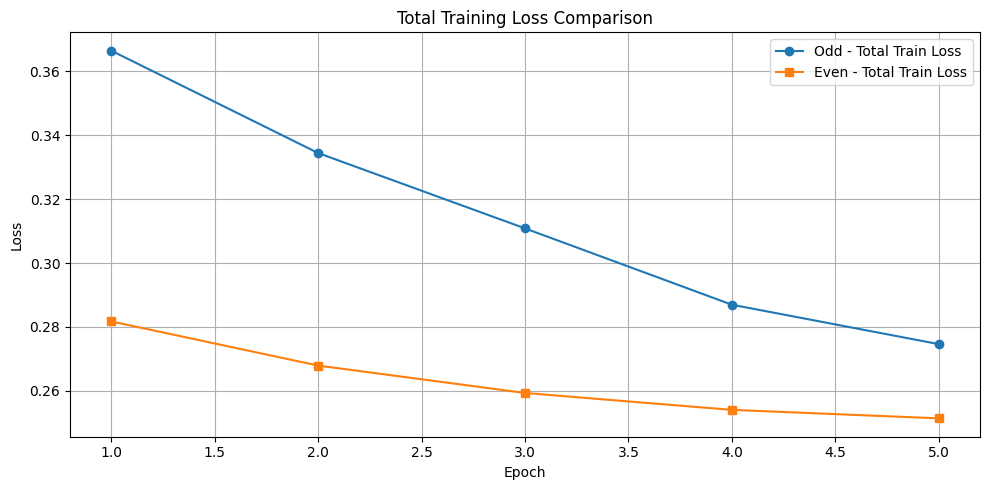

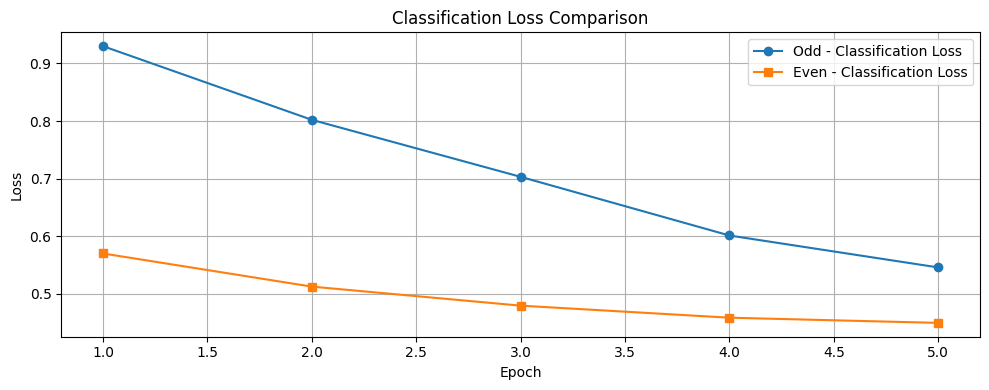

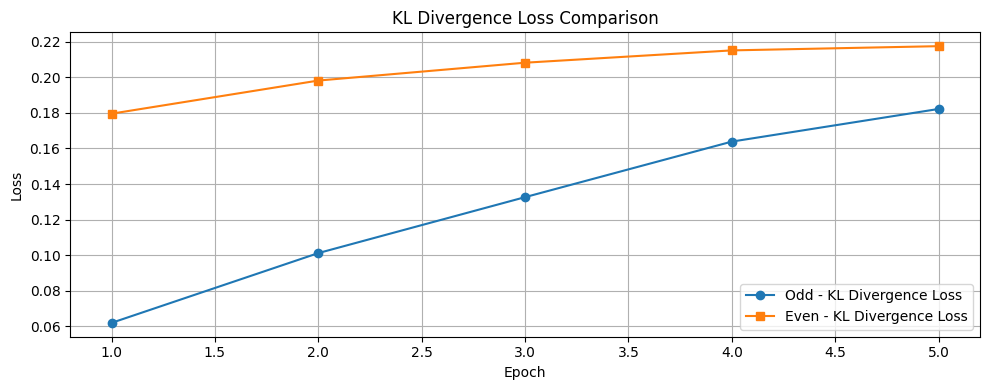

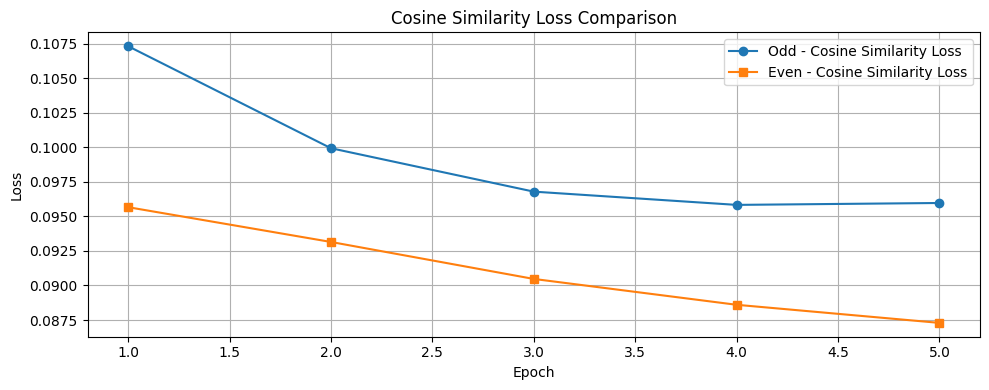

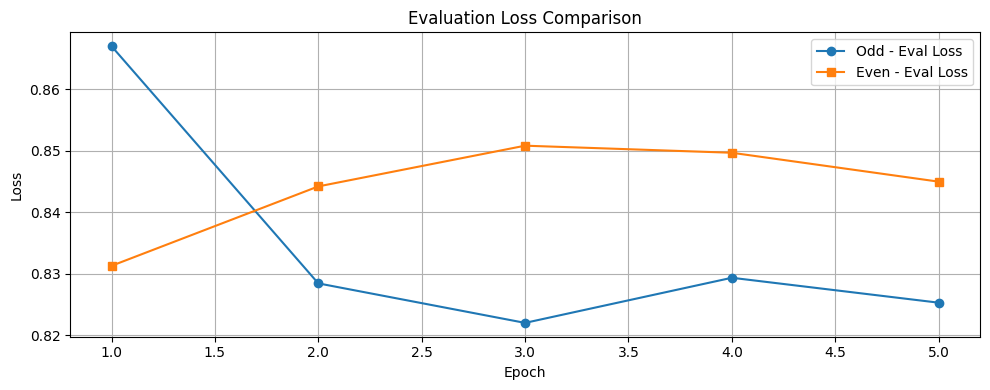

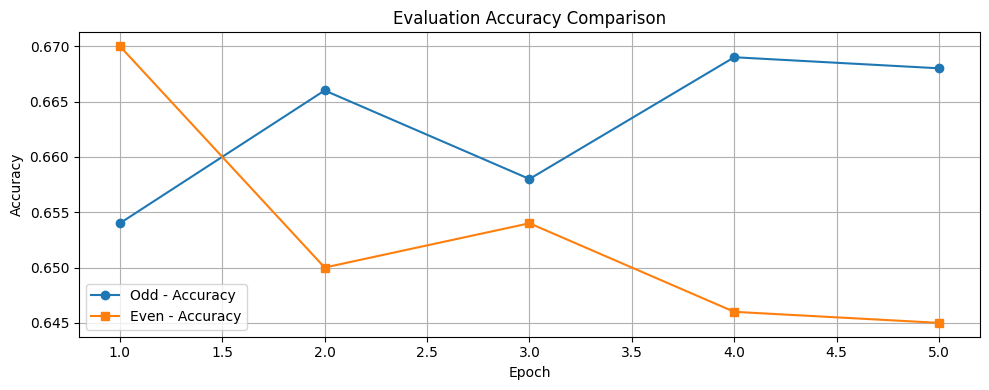

In [451]:
# visualise the result
import matplotlib.pyplot as plt

# Extract from results
epochs = list(range(1, len(odd_result['train_losses']) + 1))

# Training Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, odd_result['train_losses'], label="Odd - Total Train Loss", marker="o")
plt.plot(epochs, even_result['train_losses'], label="Even - Total Train Loss", marker="s")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Total Training Loss Comparison")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Individual Losses (CLS, DIV, COS)
loss_types = ['train_cls', 'train_div', 'train_cos']
loss_labels = ['Classification Loss', 'KL Divergence Loss', 'Cosine Similarity Loss']

for loss_key, label in zip(loss_types, loss_labels):
    plt.figure(figsize=(10, 4))
    plt.plot(epochs, odd_result[loss_key], label=f"Odd - {label}", marker="o")
    plt.plot(epochs, even_result[loss_key], label=f"Even - {label}", marker="s")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{label} Comparison")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Evaluation Loss
plt.figure(figsize=(10, 4))
plt.plot(epochs, odd_result['eval_losses'], label="Odd - Eval Loss", marker="o")
plt.plot(epochs, even_result['eval_losses'], label="Even - Eval Loss", marker="s")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Evaluation Loss Comparison")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Accuracy
odd_acc = [m['accuracy'] for m in odd_result['metrics_per_epoch']]
even_acc = [m['accuracy'] for m in even_result['metrics_per_epoch']]

plt.figure(figsize=(10, 4))
plt.plot(epochs, odd_acc, label="Odd - Accuracy", marker="o")
plt.plot(epochs, even_acc, label="Even - Accuracy", marker="s")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Evaluation Accuracy Comparison")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [452]:
# save mode
student_model_odd.save_pretrained("./models/student_odd")
print("student_odd model saved.")
student_model_even.save_pretrained("./models/student_even")
print("student_even model saved.")

student_odd model saved.
student_even model saved.


## 10. Compare LORA with Student Model

In [453]:
# Prepare 12-layer BERT Student Model
from transformers import AutoModelForSequenceClassification

student_model_lora = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=num_labels
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [454]:
# Apply LoRA Using PEFT
from peft import get_peft_model, LoraConfig, TaskType

lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    inference_mode=False,
    r=8,           # Rank
    lora_alpha=16,
    lora_dropout=0.1,
    bias="none"
)

student_model_lora = get_peft_model(student_model_lora, lora_config)
student_model_lora.print_trainable_parameters()  # Optional: to confirm only LoRA layers are trainable

trainable params: 297,219 || all params: 109,781,766 || trainable%: 0.2707


In [455]:
from transformers import AdamW

optimizer_lora = AdamW(student_model_lora.parameters(), lr=2e-5, weight_decay=0.01)


/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [456]:
from transformers import get_scheduler

num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_epochs * num_update_steps_per_epoch
num_warmup_steps = int(0.1 * num_training_steps)

scheduler_lora = get_scheduler(
    name="linear",
    optimizer=optimizer_lora,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps,
)


In [457]:
def train_lora_model(model, optimizer, scheduler, student_type="lora"):
    print(f"\nStarting LoRA training for {student_type} model...\n")

    model.to(device)
    progress_bar = tqdm(range(num_training_steps))

    # For storing logs
    train_losses = []
    eval_losses = []
    eval_metrics_list = []
    avg_metrics = {"accuracy": 0, "precision": 0, "recall": 0, "f1": 0}

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for batch in train_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}

            outputs = model(**batch)
            loss = criterion_cls(outputs.logits, batch["labels"])

            loss.backward()
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            total_loss += loss.item()
            progress_bar.update(1)

        avg_train_loss = total_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)

        # Evaluation
        model.eval()
        eval_loss = 0
        all_preds, all_labels = [], []

        for batch in eval_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            with torch.no_grad():
                outputs = model(**batch)
                loss = criterion_cls(outputs.logits, batch["labels"])
                preds = outputs.logits.argmax(dim=-1)

            eval_loss += loss.item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch["labels"].cpu().numpy())

        avg_eval_loss = eval_loss / len(eval_dataloader)
        eval_losses.append(avg_eval_loss)

        metrics = compute_metrics(np.array(all_preds), np.array(all_labels))
        eval_metrics_list.append(metrics)

        for key in avg_metrics:
            avg_metrics[key] += metrics[key]

        print(f"\nEpoch {epoch+1}/{num_epochs} — {student_type} model")
        print(f"Train Loss: {avg_train_loss:.4f}")
        print(f"Eval Loss:  {avg_eval_loss:.4f}")
        print(f"Eval Metrics: Acc={metrics['accuracy']:.4f}, Prec={metrics['precision']:.4f}, "
              f"Rec={metrics['recall']:.4f}, F1={metrics['f1']:.4f}")

    print(f"Final Average Metrics for {student_type} model:")
    for key in avg_metrics:
        print(f"  {key.capitalize()}: {avg_metrics[key]/num_epochs:.4f}")

    return {
        "train_losses": train_losses,
        "eval_losses": eval_losses,
        "metrics_per_epoch": eval_metrics_list,
        "final_avg_metrics": {k: avg_metrics[k]/num_epochs for k in avg_metrics}
    }


In [458]:
lora_result = train_lora_model(student_model_lora, optimizer_lora, scheduler_lora, student_type="lora")


Starting LoRA training for lora model...



  0%|          | 0/1565 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Epoch 1/5 — lora model
Train Loss: 1.0963
Eval Loss:  1.0802
Eval Metrics: Acc=0.4060, Prec=0.1355, Rec=0.3325, F1=0.1925


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Epoch 2/5 — lora model
Train Loss: 1.0789
Eval Loss:  1.0624
Eval Metrics: Acc=0.4080, Prec=0.4691, Rec=0.3344, F1=0.1952

Epoch 3/5 — lora model
Train Loss: 1.0555
Eval Loss:  1.0316
Eval Metrics: Acc=0.4910, Prec=0.3907, Rec=0.4427, F1=0.3738

Epoch 4/5 — lora model
Train Loss: 1.0203
Eval Loss:  1.0068
Eval Metrics: Acc=0.5000, Prec=0.4793, Rec=0.4667, F1=0.3947

Epoch 5/5 — lora model
Train Loss: 1.0008
Eval Loss:  0.9987
Eval Metrics: Acc=0.5030, Prec=0.4850, Rec=0.4706, F1=0.3992
Final Average Metrics for lora model:
  Accuracy: 0.4616
  Precision: 0.3919
  Recall: 0.4094
  F1: 0.3111


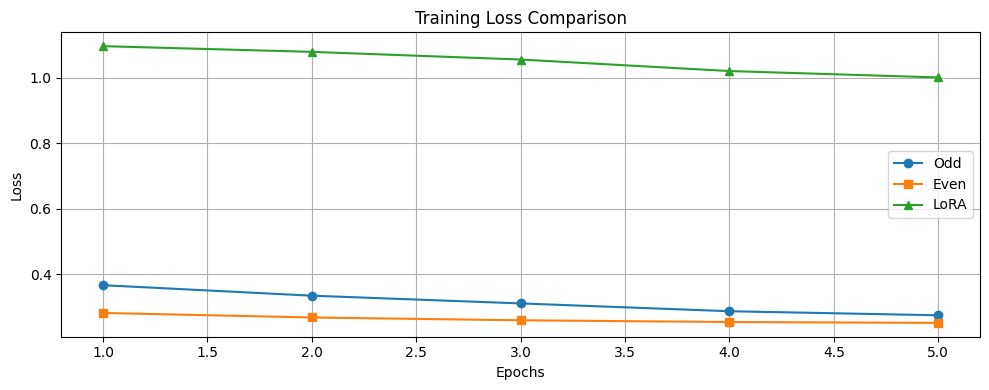

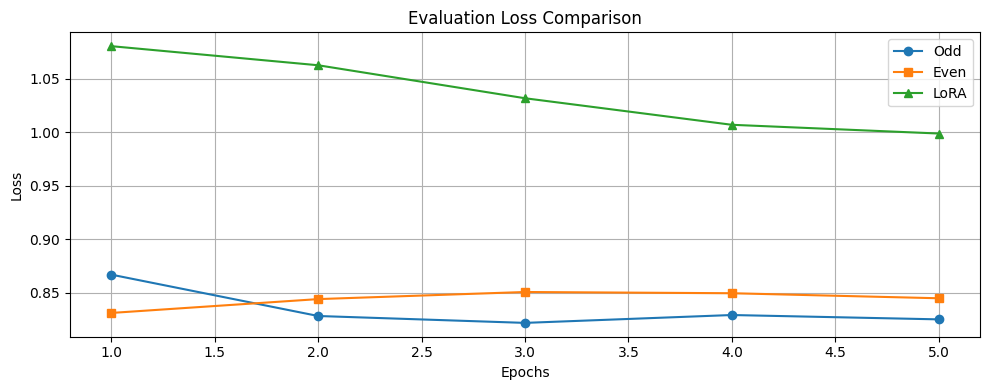

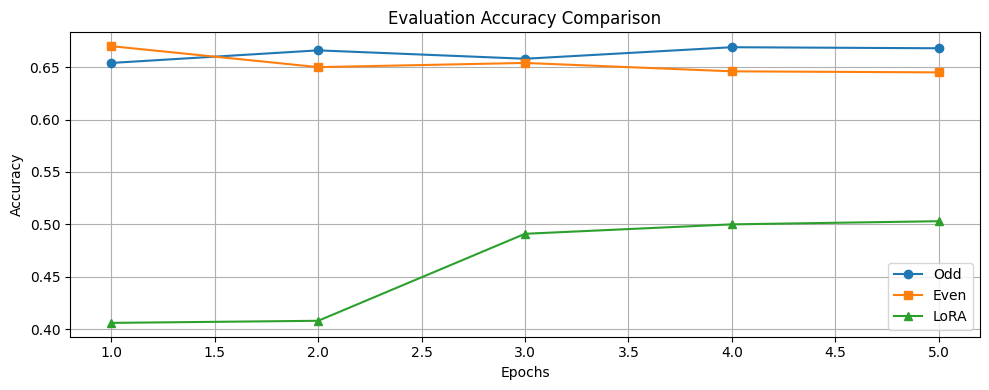

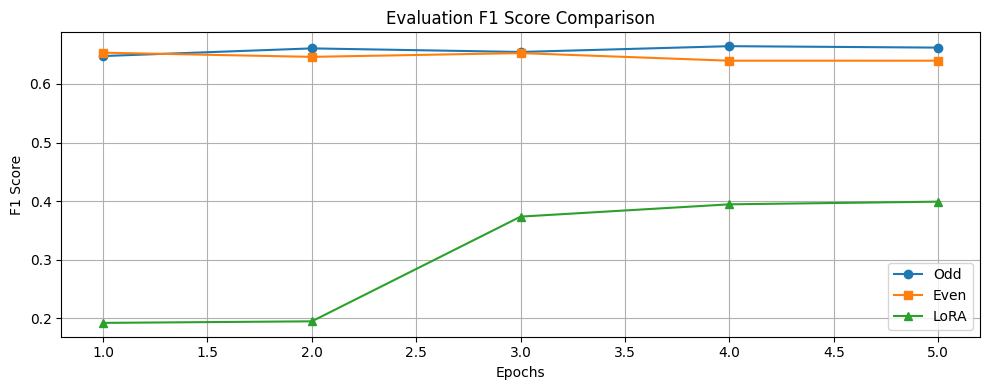

In [459]:
import matplotlib.pyplot as plt

# Epochs list
epochs = list(range(1, len(odd_result['train_losses']) + 1))

# Accuracy
odd_acc = [m['accuracy'] for m in odd_result['metrics_per_epoch']]
even_acc = [m['accuracy'] for m in even_result['metrics_per_epoch']]
lora_acc = [m['accuracy'] for m in lora_result['metrics_per_epoch']]

# F1 Score
odd_f1 = [m['f1'] for m in odd_result['metrics_per_epoch']]
even_f1 = [m['f1'] for m in even_result['metrics_per_epoch']]
lora_f1 = [m['f1'] for m in lora_result['metrics_per_epoch']]

# Plot: Training Loss
plt.figure(figsize=(10, 4))
plt.plot(epochs, odd_result['train_losses'], label="Odd", marker='o')
plt.plot(epochs, even_result['train_losses'], label="Even", marker='s')
plt.plot(epochs, lora_result['train_losses'], label="LoRA", marker='^')
plt.title("Training Loss Comparison")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot: Evaluation Loss
plt.figure(figsize=(10, 4))
plt.plot(epochs, odd_result['eval_losses'], label="Odd", marker='o')
plt.plot(epochs, even_result['eval_losses'], label="Even", marker='s')
plt.plot(epochs, lora_result['eval_losses'], label="LoRA", marker='^')
plt.title("Evaluation Loss Comparison")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot: Accuracy
plt.figure(figsize=(10, 4))
plt.plot(epochs, odd_acc, label="Odd", marker='o')
plt.plot(epochs, even_acc, label="Even", marker='s')
plt.plot(epochs, lora_acc, label="LoRA", marker='^')
plt.title("Evaluation Accuracy Comparison")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot: F1 Score
plt.figure(figsize=(10, 4))
plt.plot(epochs, odd_f1, label="Odd", marker='o')
plt.plot(epochs, even_f1, label="Even", marker='s')
plt.plot(epochs, lora_f1, label="LoRA", marker='^')
plt.title("Evaluation F1 Score Comparison")
plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [460]:
student_model_lora.save_pretrained("./models/lora_model")
print("LoRA model saved.")

LoRA model saved.


## 11. Evalute and Save the best model

In [471]:
from transformers import AutoModelForSequenceClassification

sm_odd = AutoModelForSequenceClassification.from_pretrained("./models/student_odd")
sm_even = AutoModelForSequenceClassification.from_pretrained("./models/student_even")

# Specify the correct number of labels when loading the LoRA model
num_labels = 3 # Assuming you have 3 classes
sm_lora = AutoModelForSequenceClassification.from_pretrained("./models/lora_model", num_labels=num_labels)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [464]:
def evaluate_model_on_test(model, test_dataloader, name=""):
    model.eval()
    model.to(device)

    all_preds, all_labels = [], []
    total_loss = 0

    for batch in test_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
            loss = criterion_cls(outputs.logits, batch["labels"])
            total_loss += loss.item()

            preds = outputs.logits.argmax(dim=-1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch["labels"].cpu().numpy())

    metrics = compute_metrics(np.array(all_preds), np.array(all_labels))
    avg_loss = total_loss / len(test_dataloader)

    print(f"{name} Test Performance:")
    print(f"  Loss:      {avg_loss:.4f}")
    print(f"  Accuracy:  {metrics['accuracy']:.4f}")
    print(f"  Precision: {metrics['precision']:.4f}")
    print(f"  Recall:    {metrics['recall']:.4f}")
    print(f"  F1-score:  {metrics['f1']:.4f}")

    return metrics, avg_loss


In [472]:
metrics_odd, loss_odd = evaluate_model_on_test(sm_odd, test_dataloader, name="Odd Layer")
metrics_even, loss_even = evaluate_model_on_test(sm_even, test_dataloader, name="Even Layer")
metrics_lora, loss_lora = evaluate_model_on_test(sm_lora, test_dataloader, name="LoRA")


Odd Layer Test Performance:
  Loss:      0.8413
  Accuracy:  0.6620
  Precision: 0.6513
  Recall:    0.6532
  F1-score:  0.6521
Even Layer Test Performance:
  Loss:      0.8413
  Accuracy:  0.6620
  Precision: 0.6513
  Recall:    0.6532
  F1-score:  0.6521
LoRA Test Performance:
  Loss:      1.0147
  Accuracy:  0.4890
  Precision: 0.3996
  Recall:    0.4553
  F1-score:  0.3833


In [469]:
best_model = None
best_model_name = ""
best_f1 = max(metrics_odd["f1"], metrics_even["f1"], metrics_lora["f1"])

if metrics_odd["f1"] == best_f1:
    best_model = student_model_odd
    best_model_name = "student_model_odd"
elif metrics_even["f1"] == best_f1:
    best_model = student_model_even
    best_model_name = "student_model_even"
else:
    best_model = student_model_lora
    best_model_name = "student_model_lora"

print(f"Best Model Selected: {best_model_name} (F1: {best_f1:.4f})")


Best Model Selected: student_model_odd (F1: 0.6521)


In [470]:
# Create a folder to store the model
save_path = f"./saved_models/{best_model_name}"
best_model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

print(f"\n Model and tokenizer saved to: {save_path}")



 Model and tokenizer saved to: ./saved_models/student_model_odd
